In [1]:
%matplotlib inline  

import pandas as pd
import numpy as np
import pandas_highcharts.core
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot 

import os

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "IMAM.settings")

from django.conf import settings
from home.management.commands.load_data import rename_cols, assign_state_lga_num

import django
django.setup()

from home.models import Stock, Site

In [2]:
engine = create_engine(
    'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{NAME}'.format(**settings.DATABASES['default']))
df = pd.read_sql_query("select * from stock;", con=engine)

In [3]:
df.head()

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,level,...,rutf_bal_carton,rutf_bal_sachet,rutf_out,rutf_bal,f75_bal_carton,f75_bal_sachet,f100_bal_carton,f100_bal_sachet,confirm,unique
0,0,acf7f7a2-393b-4a13-bdb5-4ca4aab05353,2347035678763,Hauwa Zoakah.,"Imam Supervision, Imam Supervision 2, Imam Sup...",2,2016-11-30 13:11:23,2016-11-30 13:11:23,None,First,...,None,None,None,None,None,None,None,NaN,None,2347035678763 2016-11-30 13:11:23
1,1,acf7f7a2-393b-4a13-bdb5-4ca4aab05353,2347035678763,Hauwa Zoakah.,"Imam Supervision, Imam Supervision 2, Imam Sup...",2,2016-11-30 13:16:31,2016-11-30 13:16:31,None,First,...,None,None,None,None,None,None,None,NaN,None,2347035678763 2016-11-30 13:16:31
2,2,acf7f7a2-393b-4a13-bdb5-4ca4aab05353,2347035678763,Hauwa Zoakah.,"Imam Supervision, Imam Supervision 2, Imam Sup...",2,2016-11-30 13:21:14,2016-11-30 13:21:15,None,First,...,None,None,None,None,None,None,None,NaN,None,2347035678763 2016-11-30 13:21:14
3,3,acf7f7a2-393b-4a13-bdb5-4ca4aab05353,2347035678763,Hauwa Zoakah.,"Imam Supervision, Imam Supervision 2, Imam Sup...",2,2016-11-30 13:25:01,2016-11-30 13:25:01,None,First,...,None,None,None,None,None,None,None,NaN,None,2347035678763 2016-11-30 13:25:01
4,4,acf7f7a2-393b-4a13-bdb5-4ca4aab05353,2347035678763,Hauwa Zoakah.,"Imam Supervision, Imam Supervision 2, Imam Sup...",2,2016-11-30 13:28:36,2016-11-30 13:28:37,None,First,...,None,None,None,None,None,None,None,NaN,None,2347035678763 2016-11-30 13:28:36


In [4]:
# Missing data for weeknum
df.weeknum.unique()

array([None, u'26', u'23', u'22', u'24', u'25', u'27', u'28', u'29', u'30',
       u'31', u'32', u'33', u'34', u'35', u'36', u'37', u'38', u'39',
       u'40', u'41', u'42', u'43', u'44', u'45', u'46', u'47', u'48',
       u'49', u'50', u'51', u'52', u'1', u'2', u'3', u'4', u'5', u'6',
       u'7', u'8', u'9', u'10', u'11', u'20', u'53', u'0', u'3308', u'YES',
       u'N', u'12', u'PRO', u'STO', u'14', u'18', u'St0', u'KDM', u'19',
       u'16', u'15', u'PRO    ', u'STO     ', u'21', u'STOCK', u'Pro',
       u'Sto', u'NO', u'N0', u'Y', u'I Y C F', u'No', u'Yes', u'17',
       u'SHEHU ABDU', u'yes', u'85', u'No ', u'X', u'N ', u'O',
       u'Stock report', u'Week31', u'Yes ', u'13', u'101110001', u'St',
       u'REG ', u'821110009', u'Wk50', u'Wk49', u'IYCM', u'y', u'PRo',
       u'PR0', u'ST0', u'0.', u'6.69', u'52.1', u'STOCKS', u'Oky',
       u'Week6', u'1.0', u'YES COMFRIM', u'PRO   ', u'NFP', u'YE', u'300',
       u'STO '], dtype=object)

In [ ]:
# Make sure that supervision staff can submit reports for sites. 

In [2]:
# Do not need to import data when it is directly available from postgres

# df = pd.ExcelFile('/home/robert/Downloads/sto.xlsx').parse('Runs')


In [5]:
# rename_cols(df)

In [5]:
df.keys()

Index([u'index', u'contact_uuid', u'urn', u'name', u'groups', u'siteid',
       u'first_seen', u'last_seen', u'weeknum', u'level', u'self_report',
       u'sto_siteid', u'sto_type', u'type', u'rutf_in', u'rutf_used_carton',
       u'rutf_used_sachet', u'rutf_bal_carton', u'rutf_bal_sachet',
       u'rutf_out', u'rutf_bal', u'f75_bal_carton', u'f75_bal_sachet',
       u'f100_bal_carton', u'f100_bal_sachet', u'confirm', u'unique'],
      dtype='object')

In [6]:
df['siteid'] = pd.to_numeric(df.siteid, errors='coerce')
df['weeknum'] = pd.to_numeric(df.weeknum, errors='coerce')
df['rutf_bal_carton'] = pd.to_numeric(df.rutf_bal_carton, errors='coerce')
df['rutf_bal_sachet'] = pd.to_numeric(df.rutf_bal_sachet, errors='coerce')

df = df.query('siteid==siteid').query('0<siteid<3999990999')
# 2015 had 53 weeks
# 2016 had 52 weeks - current data is only for weeknumbers from 22-2016 to present
df = df.query('weeknum==weeknum').query('0.99<weeknum<53')
df = df.query('rutf_bal_carton==rutf_bal_carton').query('0<=rutf_bal_carton<9999')
df = df.query('rutf_bal_sachet==rutf_bal_sachet').query('0<=rutf_bal_sachet<9999')

df['siteid'] = df.siteid.astype('int')
df['weeknum'] = df.weeknum.astype('int')
df['rutf_bal_carton'] = df.rutf_bal_carton.astype('int')
df['rutf_bal_sachet'] = df.rutf_bal_sachet.astype('int')

In [7]:
len(df)

28048

In [8]:
# Drop unvalidated data
df = df.query('confirm=="Yes"')

In [9]:
# Before filter - Sort data
df = df.sort_values(by='last_seen', ascending = False)
df = df.drop_duplicates(['siteid', 'weeknum', 'type'], keep ='first')

len(df)

21295

In [10]:
df['year'] = df['last_seen'].map(lambda x: x.year)

df['last_seen_weeknum'] = df['last_seen'].map(lambda x: x.week)
df['year'] = np.where(df['last_seen_weeknum'] < df['weeknum'],
                                        df['year'] - 1, df['year'])

In [16]:
assign_state_lga_num(df)
df.state_num.unique()

array(['17', '33', '35', '20', '16', '36', '2', '8', '21', '19', '18', '5',
       '3', '1', '80'], dtype=object)

In [11]:
# Quantity of RUTF in last (most recent) stock report

sorted(df.query('year==2017').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_carton'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 62,
 63,
 66,
 67,
 68,
 69,
 70,
 71,
 74,
 77,
 79,
 81,
 84,
 85,
 86,
 91,
 94,
 95,
 96,
 103,
 109,
 112,
 118,
 123,
 127,
 130,
 133,
 140,
 150,
 174,
 175,
 180,
 181,
 183,
 258,
 269,
 499]

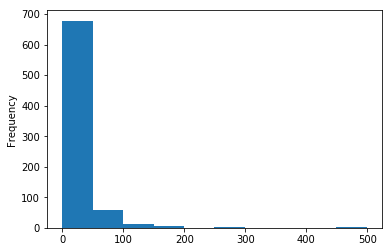

In [28]:
# most recent stock report for sites
df.query('year==2017').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_carton'].plot.hist()

In [37]:
# most recent stock report for sites
print df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_carton']
print df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_sachet']

28659    24
Name: rutf_bal_carton, dtype: int64
28659    43
Name: rutf_bal_sachet, dtype: int64


In [43]:
 df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_sachet']

Series([], Name: rutf_bal_sachet, dtype: int64)

In [45]:
 df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['weeknum']

28659    1
Name: weeknum, dtype: int64